In [4]:
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

In [7]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, n_feats, res_scale=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        )
        self.res_scale = res_scale

    def forward(self, x):
        return x + self.res_scale * self.block(x)

class Upsampler(nn.Sequential):
    def __init__(self, scale, n_feats):
        m = []
        if scale in [2, 3]:
            m += [nn.Conv2d(n_feats, n_feats * scale * scale, 3, 1, 1), nn.PixelShuffle(scale)]
        elif scale == 4:
            for _ in range(2):
                m += [nn.Conv2d(n_feats, n_feats * 4, 3, 1, 1), nn.PixelShuffle(2)]
        else:
            raise NotImplementedError(f'Unsupported scale: {scale}')
        super().__init__(*m)

class EDSR(nn.Module):
    def __init__(self, scale=2, n_resblocks=16, n_feats=64):
        super().__init__()
        self.head = nn.Conv2d(3, n_feats, 3, 1, 1)
        body = [ResidualBlock(n_feats) for _ in range(n_resblocks)]
        body.append(nn.Conv2d(n_feats, n_feats, 3, 1, 1))
        self.body = nn.Sequential(*body)
        self.tail = nn.Sequential(Upsampler(scale, n_feats), nn.Conv2d(n_feats, 3, 3, 1, 1))

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        x = x + res
        x = self.tail(x)
        return x

In [8]:
def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    psnr = -10 * torch.log10(mse)
    return psnr

class EDSRLightningModule(pl.LightningModule):
    def __init__(self, scale=2, lr=1e-4):
        super().__init__()
        self.model = EDSR(scale=scale)
        self.criterion = torch.nn.L1Loss()
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self(lr)
        loss = self.criterion(sr, hr)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self(lr)
        loss = self.criterion(sr, hr)
        psnr = calculate_psnr(sr, hr)
        self.log('val_loss', loss)
        self.log('val_psnr', psnr)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [9]:
checkpoint = torch.load('../logs/edsr_lightning/version_1/checkpoints/epoch=49-step=2500.ckpt')
model = EDSRLightningModule(scale=3, lr=1e-4)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

EDSRLightningModule(
  (model): EDSR(
    (head): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (body): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (3): ResidualBlock(
        (block): Sequential(

In [13]:
img_LR = np.array(Image.open('/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_valid_LR_bicubic/X3/0801x3.png').convert('RGB'))
img_HR = np.array(Image.open('/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_valid_HR/0801.png').convert('RGB'))

img_LR_tensor = torch.tensor(img_LR).permute(2, 0, 1).unsqueeze(0).float() / 255.0
img_HR_tensor = torch.tensor(img_HR).permute(2, 0, 1).unsqueeze(0).float() / 255.0
img_SR_tensor = model(img_LR_tensor)

In [14]:
def show_images(lr, hr, sr):
    """Display LR and HR images side by side."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(lr.permute(1, 2, 0).numpy(), )
    axes[0].set_title('Low Resolution Image')
    axes[0].axis('off')

    axes[1].imshow(hr.permute(1, 2, 0).numpy())
    axes[1].set_title('High Resolution Image')
    axes[1].axis('off')
    
    axes[2].imshow(sr.permute(1, 2, 0).detach().numpy())
    axes[2].set_title('Super Resolution Image')
    axes[2].axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08415231..1.0857528].


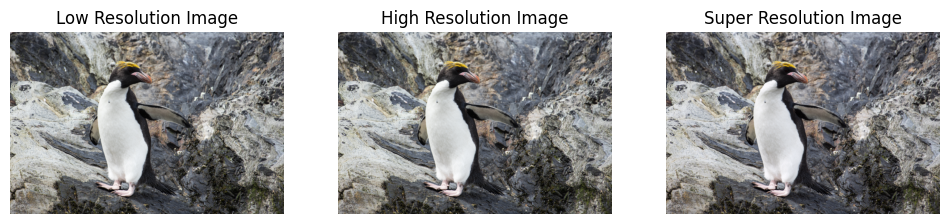

In [15]:
show_images(img_LR_tensor.squeeze(0), img_HR_tensor.squeeze(0), img_SR_tensor.squeeze(0))

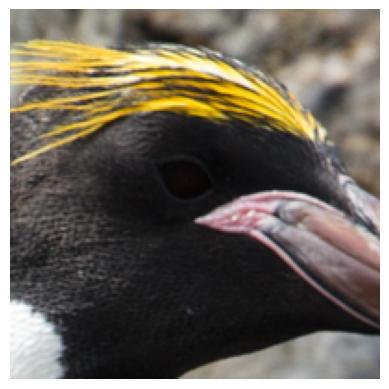

In [16]:
hr_ = img_HR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
patch = hr_[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06405184..1.0857528].


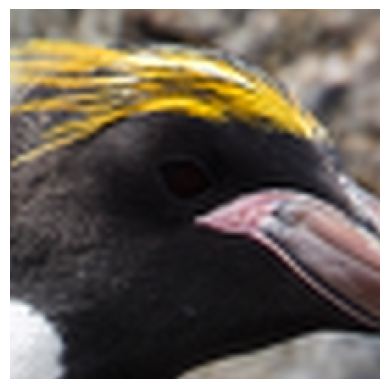

In [17]:
sr_ = img_SR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
patch = sr_[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02176213..0.9414867].


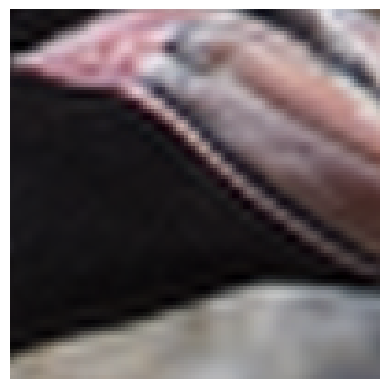

In [18]:
patch = sr_[300:400, 900:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()